## E-tivity 5
### Name: Muhammad Umer Farooq
### Student ID: 22402098

In [150]:
#imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#import warnings
#warnings.filterwarnings("ignore")

## EDA 
Here, the goal is to check different attributes of the dataset, look for missing values, look for outliers, and if required take necessary actions regarding missing values, and perform data transformation with an aim to train a good model. 

In [151]:
# Read the dataset in a pandas data frame
data_frame = pd.read_csv("insurance.csv")
data_frame.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [152]:
# Let's check for missing values in the dataset 
data_frame.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

Let's obtain some basic statistics about the numeric attributes in the data

In [153]:
data_frame.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The mean value for "children" attribute is 0. Let's further investigate it. 

In [154]:
data_frame.loc[(data_frame["children"] == 0)]

,age,gender,bmi,children,smoker,region,insurance_cost
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
4,18,female,35.625,0,no,northeast,2211.13075
6,18,female,30.115,0,no,northeast,21344.84670
7,18,male,23.750,0,no,northeast,1705.62450
...,...,...,...,...,...,...,...
1331,64,female,39.700,0,no,southwest,14319.03100
1332,64,female,35.970,0,no,southeast,14313.84630
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790


We have 1338 samples in the dataset. Among 1338 samples 574 samples report no chidren. The statistical data about the dataset has already revealed that the range of the "age" attribute is (18, 64) inclusive. Given the range of age in the dataset, the children data seems fine.

In the given dataset we have two nominal attributes/features, i.e., gender and region. Therefore, we will appy OneHot encoding on these attibutes.

In [155]:
# I am reading the csv again here, so that running this cell doesn't give an error (as we have used get_dummies).
data_frame = pd.read_csv("insurance.csv")
data_frame = pd.get_dummies(data_frame, columns = ["gender", "region"])

# Let's look for unique values in the smoker attribute
print("Unique values for smoker ", data_frame["smoker"].unique())
# Let's apply remapper on the smoker attribute
smoker_mapper = {"no" : 0 , "yes" : 1}
data_frame["smoker"] = data_frame["smoker"].replace(smoker_mapper)

data_frame.head()

Unique values for smoker  ['no' 'yes']


,age,bmi,children,smoker,insurance_cost,gender_female,gender_male,region_northeast,region_northwest,region_southeast,region_southwest
0,18,33.770,1,0,1725.55230,0,1,0,0,1,0
1,18,34.100,0,0,1137.01100,0,1,0,0,1,0
2,18,26.315,0,0,2198.18985,1,0,1,0,0,0
3,18,38.665,2,0,3393.35635,1,0,1,0,0,0
4,18,35.625,0,0,2211.13075,1,0,1,0,0,0


Let's look for outliers in the dataset. 

<AxesSubplot:>

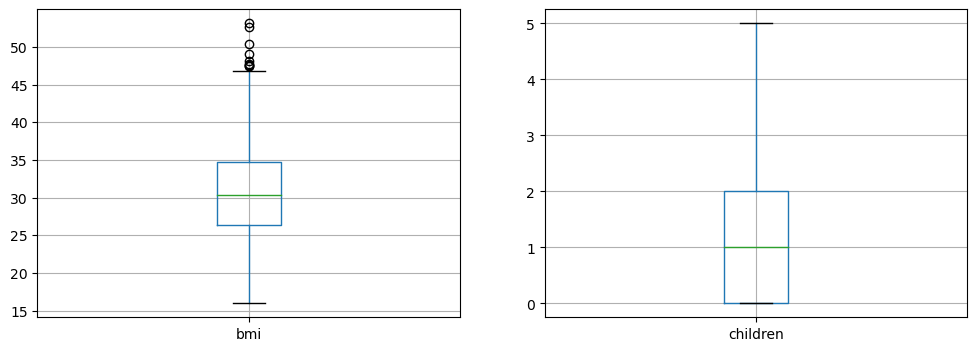

In [156]:
# The relevant fields to look for outliers in our data set is "bmi" and "children".
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
data_frame.boxplot(column=["bmi"])

ax2 = fig.add_subplot(1,2,2)
data_frame.boxplot(column=["children"])

BMI has outliers, and the outliers are too big values for BMI. Hence, we need to provide special treatment to this attribute. The transformation of BMI will include application of RubustScalar followed by log transformation.
Let's also visualize the distibution of both attributes. 

<AxesSubplot:>

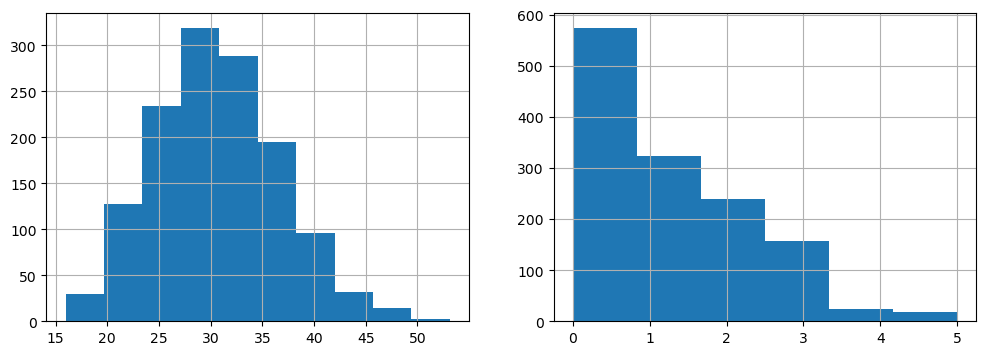

In [157]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
data_frame["bmi"].hist(bins=10)

ax2 = fig.add_subplot(1,2,2)
data_frame["children"].hist(bins=6)

### EDA Conclusions
- The preprocessing pipleline needs to apply the following on the BMI attribute: RobustScalar and log transformation.
- The preprocessing pipeline needs to apply MinMaxScaler on children attribute (the reason for selecting MinMaxScalar is that children attribute doesn't follow normal distribution). 
- As we have different transformations for different colums, therefore our preprocessing pipeline will be part of column transformer.

### Partition Data in Train and Test Sets

In [158]:
y = data_frame["insurance_cost"]
X = data_frame.drop("insurance_cost", axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = pd.DataFrame(X_train, columns = ["age", "bmi", "children", "smoker", "gender_female", "gender_male", "region_northeast", "region_northwest", "region_southeast", "region_southwest"])
X_test = pd.DataFrame(X_test, columns = ["age", "bmi", "children", "smoker" , "gender_female", "gender_male", "region_northeast", "region_northwest", "region_southeast", "region_southwest"])
y_train = pd.DataFrame(y_train, columns = ["insurance_cost"])
y_test = pd.DataFrame(y_test, columns = ["insurance_cost"])
#print(X_train.head(5))
#print(X_test.head(5)) 
#print(y_train.head(5)) 
#print(y_test.head(5)) 

In [159]:
def apply_log_transform(input_data):
    min_value = input_data.min()
    if min_value < 0:
        min_value = (-2)*min_value 
    return np.log(input_data + min_value)

### Create Pipelines and Using Random Forest Regression for Model Training

In [160]:
outlier_feature = ["bmi"]
non_outlier_features = ["age", "children", "smoker", "gender_female", "gender_male", "region_northeast", "region_northwest", "region_southeast", "region_southwest"]
# Create a pipeline for preprocessing outlier feature
outlier_transformer = Pipeline(steps = [("scaler", RobustScaler()), ("log", FunctionTransformer(apply_log_transform))])
# Create a pipeline for preprocessing non-outlier features
non_outlier_transformer = Pipeline(steps = [("scaler", MinMaxScaler())])

# Create a column transformer
preprocessor = ColumnTransformer(transformers = [("outlier" , outlier_transformer, outlier_feature), ("non_outlier", non_outlier_transformer, non_outlier_features)])

# The final high-level pipeline
pipeline = Pipeline(steps = [("preprocess-pipeline", preprocessor), 
                         ("reduce_dim", "passthrough"), 
                         ('regression', RandomForestRegressor(n_estimators=10))])


MAX_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 6, 4, 8]

param_grid = [{"reduce_dim" : [PCA()], 
               "reduce_dim__n_components" : MAX_FEATURES_OPTIONS, 
               "regression__max_depth" : MAX_DEPTH_OPTIONS
              }, 
              {
                  'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
                  'reduce_dim__n_features_to_select': MAX_FEATURES_OPTIONS,
                  'regression__max_depth': MAX_DEPTH_OPTIONS
              }
            ]

search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.801:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regression__max_depth': 4}


### Linear Regression Pipeline

In [161]:
pipe = Pipeline(steps=[('preprocess', preprocessor), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [162]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.741:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__normalize': True}


### MLP Regression Pipeline

In [163]:
pipe = Pipeline(steps=[('preprocess', preprocessor), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', MLPRegressor())])

In [164]:
N_FEATURES_OPTIONS = [2, 6, 11]

param_grid = [
    {
    'reduce_dim' : [PCA(iterated_power=7)],
    'reduce_dim__n_components' : N_FEATURES_OPTIONS,
    'regresson__hidden_layer_sizes': [2,3,4,6,7],
    'regresson__activation': ['identity','logistic','tanh','relu'],
    'regresson__solver': ['lbfgs','sgd','adam'],
    'regresson__learning_rate':['constant','invscaling','adaptive'],
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__hidden_layer_sizes': [2,3,4,6,7],
        'regresson__activation': ['identity','logistic','tanh','relu'],
        'regresson__solver': ['lbfgs','sgd','adam'],
        'regresson__learning_rate':['constant','invscaling','adaptive'],
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.827:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__activation': 'relu', 'regresson__hidden_layer_sizes': 7, 'regresson__learning_rate': 'adaptive', 'regresson__solver': 'lbfgs'}


### Discussion on Model Training Results
Model training has been done using the following methods:
- Random Forest Regressor
- Linear Regression 
- MLP Regressor 

For dimension reduction, the following methods were used:
- Principle Component Analysis (PCA)
- Recursive Feature Elimination (RFE)

Single run of the model training has demonstarted that MLP regressor has the best model training result, followed by Random Forest Regressor, and Linear Regression. MLP Regressor, Random Forest Regressor, and Linear Regression have demonstarted CV score of 82.8%, 80.7%, and 74.9% respectively. Interestingly, RFE with SVM estimator comes out to be the best method for dimensionality reduction for all the trained methods. However, in case of the Random Forest Regressor method the features were reduced to 6, and both other methods demonstarte best performace when all the features in the data set are selected. Furthermore, the training time for MLP Regressor is significantly high compared to the Random Forest Regressor tarining time. Random Forest Regressor demonstartes the two advantages over MLP Regressor:
- Lower feature - reduced memory requirement 
- Lower training time - lower CPU resource

The benefit demonstarted by MLP Regressor over Random Forest Regressor in terms of CV score is small, hence if resource requirement is an issue, Random Forest Regressor is better else MLP regressor is the best option.

### Evaluating Models on Test Data
Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- Mean squared error (MSE)
- Mean absolute error (MAE)
- 1-relative squared error (R2)

This will help us to choose the better regressor for our problem.

In [111]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

The following piece of code will collect the metrices corresponding to model performace on test data.

In [114]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(X_test, y_test, MLP_best_model)

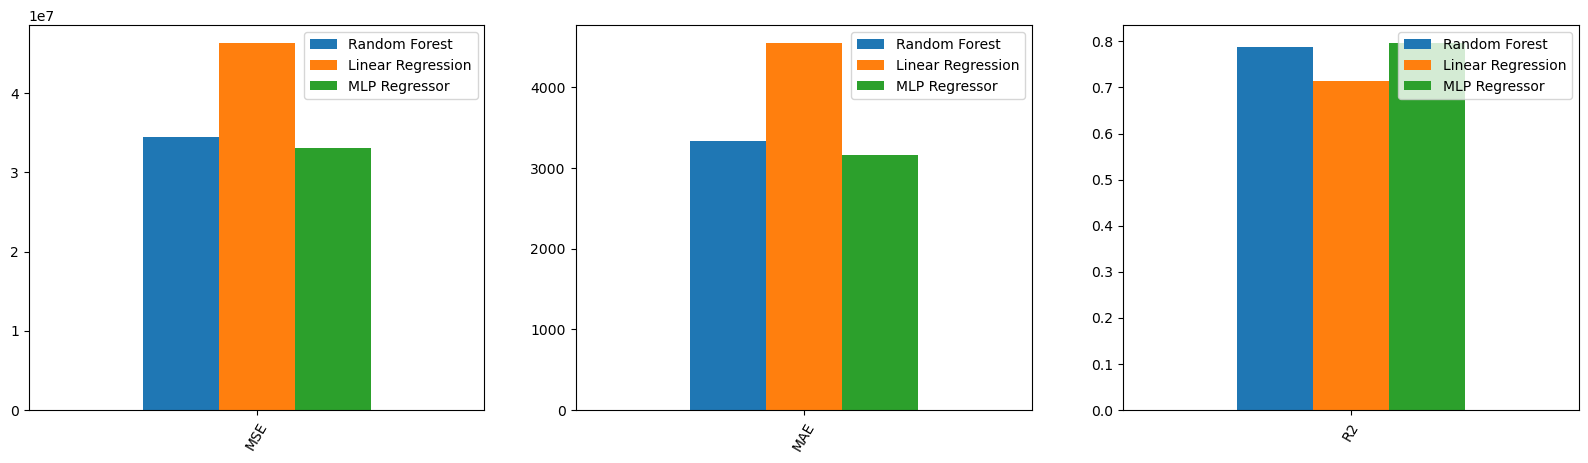

In [119]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'MLP Regressor' : MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'MLP Regressor' : MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'MLP Regressor' : MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=60, ax=axes[0])
df_mae.plot.bar(rot=60, ax=axes[1])
df_r2.plot.bar(rot=60, ax=axes[2])

plt.show()

### Discussion
The above plots demonstrate that for "MSE" and "MAE" metrics MLP Regressor demonstrates better performance, however the difefrence is not significant compared to Random Forest Regressor. This result is consistent with the training data set result. However, on the test data set, Linear Regression has demonstarted better performance related to R2 metric. 

Overall, the results are consistent with the training data set results, and mostly the conclusions drawn on the training data set results generally hold on the test data set results. 

### Storing the Best Model
As in the task 3, I need to experiment with couple of other dimensionality reduction techniques, hence at this point we are not sure whether we have the best model available to us or not. After task 3, the best model will be saved. 

### Task 3
In task 3, I will use the following dimensionality reduction techniques:
- Select K Best
- Non-Negative Matrix Factorization (NMF)

In [165]:
pipeline = Pipeline(steps = [("preprocess-pipeline", preprocessor), 
                         ("reduce_dim", "passthrough"), 
                         ('regression', RandomForestRegressor(n_estimators=10))])

In [166]:
MAX_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 6, 4, 8]

param_grid = [{"reduce_dim" : [NMF(max_iter=1_000)], 
               "reduce_dim__n_components" : MAX_FEATURES_OPTIONS, 
               "regression__max_depth" : MAX_DEPTH_OPTIONS
              }, 
              {
                  'reduce_dim': [SelectKBest(mutual_info_regression)], # mutual_info_regression is used for regression
                  'reduce_dim__k': MAX_FEATURES_OPTIONS,
                  'regression__max_depth': MAX_DEPTH_OPTIONS
              }
            ]

search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.799:
Best parameters:  {'reduce_dim': SelectKBest(k=6,
            score_func=<function mutual_info_regression at 0x000001C3C3E514C0>), 'reduce_dim__k': 6, 'regression__max_depth': 4}


### Linear Regression Pipeline

In [167]:
pipe = Pipeline(steps=[('preprocess', preprocessor), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [168]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [NMF(max_iter=1_000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(mutual_info_regression)], # mutual_info_regression is used for regression,
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.741:
Best parameters:  {'reduce_dim': SelectKBest(k=6,
            score_func=<function mutual_info_regression at 0x000001C3C3E514C0>), 'reduce_dim__k': 6, 'regresson__normalize': False}


### MLP Regression Pipeline

In [147]:
pipe = Pipeline(steps=[('preprocess', preprocessor), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', MLPRegressor())])

In [148]:
N_FEATURES_OPTIONS = [2, 6, 11]

param_grid = [
    {
    'reduce_dim' : [NMF(max_iter=1_000)],
    'reduce_dim__n_components' : N_FEATURES_OPTIONS,
    'regresson__hidden_layer_sizes': [2,3,4,6,7],
    'regresson__activation': ['identity','logistic','tanh','relu'],
    'regresson__solver': ['lbfgs','sgd','adam'],
    'regresson__learning_rate':['constant','invscaling','adaptive'],
    },
    {
        'reduce_dim': [SelectKBest(mutual_info_regression)], # mutual_info_regression is used for regression
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'regresson__hidden_layer_sizes': [2,3,4,6,7],
        'regresson__activation': ['identity','logistic','tanh','relu'],
        'regresson__solver': ['lbfgs','sgd','adam'],
        'regresson__learning_rate':['constant','invscaling','adaptive'],
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.806:
Best parameters:  {'reduce_dim': SelectKBest(k=6,
            score_func=<function mutual_info_regression at 0x000001C3C3E514C0>), 'reduce_dim__k': 6, 'regresson__activation': 'relu', 'regresson__hidden_layer_sizes': 7, 'regresson__learning_rate': 'adaptive', 'regresson__solver': 'lbfgs'}


### Discussion
The best model obtained using "Select K Best" and "NMF" dimensionality reduction methods is also MLP regressor, followed by Random forest regressor, and linear regression. This finding is consistent with the finding of task 2. However, the selected MLP regressor model in case of Task 2 used 11 features, but in this case the best MLP regressor model only needs 6 features. At the same time, the best MLP regressor model obtained in task 3 demonstrates slighty lower best CV score comapred to the scored demonstrated by the MLP regressor in task 2. However, the difference in score doesn't seem to be significant. Hence, the conclusion here is that dimensionality reduction method should be carefully selected as it impacts the memory requirement, and a model's performance. In this case, it has been demonstarted that the select K Best dimensionality reduction method can acheive similar performance to the best MLP regressor method selected in task 2, however the current method can acheive the performance with nearly 50% less features.  

The following piece of code will collect the metrices corresponding to model performace on test data.

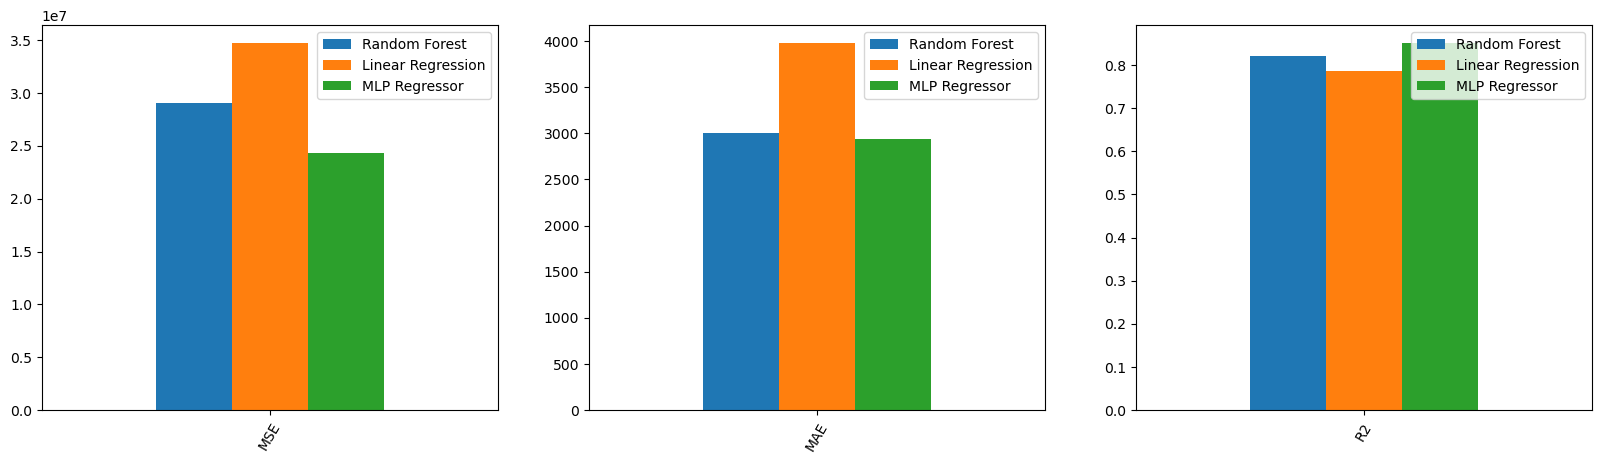

In [149]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(X_test, y_test, MLP_best_model)

df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'MLP Regressor' : MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'MLP Regressor' : MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'MLP Regressor' : MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=60, ax=axes[0])
df_mae.plot.bar(rot=60, ax=axes[1])
df_r2.plot.bar(rot=60, ax=axes[2])

plt.show()

### Conclusions
The above plots demonstrate that on the test data, mostly MLP regressor demonstrates best performace. These results are also consistent with the results shown in Task 2. The conclusion is that: it is important to evaluate different dimensionality reduction methods as it could help to select reduce memory requirement for memory training mostly without negatively impacting the model's performace. 